# Applying GrandPrix on droplet based single-cell RNA-seq of mouse embryonic stem cells
_Sumon Ahmed_, 2017

This notebooks shows how GrandPrix with informative prior over the latent space can be used to infer one dimensional pseudotime from single cell RNA-seq generated using droplet barcoding. Models with both informative and non-informative priors are examined and compared with the diffusion pseudotime (DPT) framework.

Our model supports mixed precision computation. This notebook is an example of running the model with lower precision floating point. 

In [1]:
import sys
sys.argv.append("float32")

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from GrandPrix import GrandPrix
from utils import correlation_dpt

In [3]:
def MapTo01(y):
    return (y.copy() - y.min(0)) / (y.max(0) - y.min(0))

## Data description

<a href="https://www.ncbi.nlm.nih.gov/pubmed/26000487" target="_blank">Klein et al. (2015)</a> developed a method termed inDrop (indexing droplet) based on droplet microfluidics and assayed the gene expression profiles and differentiation heterogeneity of mouse stem cells after leukemia inhibitory factor (LIF) withdrawal.

<a href="https://www.ncbi.nlm.nih.gov/m/pubmed/27571553/" target="_blank">Haghverdi et al. (2016)</a> have applied cell cycle normalization on this data and used it to infer diffusion pseudotime (DPT).

The "dropSeq.csv" file contains cell cycle normalized expression profiles of $2717$ cells and $2047$ genes.

The "dropsecMeta.csv" file contains the additional information of the data such as capture time of each cells, diffusion pseudotimes, etc.

In [4]:
Y = pd.read_csv('data/dpt/dropSeq.csv', index_col=[0]).T
mData = pd.read_csv('data/dpt/dropsecMeta.csv', index_col=[0])

In [5]:
N, D = Y.shape

In [6]:
mData.head()

,capture.orig,dpt,pt_np_32,pt_np_32_trun,pt_np_64,pt_np_64_trun,pt_wp_32,pt_wp_32_trun
Cell-0,1,0.014755,0.106019,0.072093,0.196619,0.133701,0.154985,0.105390
Cell-1,1,0.010067,0.106081,0.072135,0.274731,0.186817,0.106716,0.072567
Cell-2,1,0.009285,0.199391,0.135586,0.185167,0.125913,0.109926,0.074750
Cell-3,1,0.042065,0.222770,0.151484,0.303305,0.206247,0.156400,0.106352
Cell-4,1,0.021697,0.187327,0.127382,0.267089,0.181621,0.135322,0.092019


In [7]:
dpt = mData['dpt'].values

## Model Construction
The first step of using the GrandPrix is to initialize the model with the observed data

In [8]:
model = GrandPrix(Y.values, mData)

As we are using $32$ bits floating point, the jitter_level has been set to larger values to avoid numerical problems.

In [9]:
model.set_jitter_level(1e-1)

### Build sparse Bayesian GPLVM model
Following initializations are essential for better optimizations. If not initialized, the default values will be used.  
<ul>
<li>__kernel:__ Covariance function to define the mappring mapping from the latent space to the data space in Gaussian process prior. 
<!--
    <ul>
        <li>name</li>
        <li>ls</li>
        <li>var</li>
        <li>period</li>
    </ul>
-->
</li>

<li>__vParams:__ Variational Parameters
    <ul>
        <li>Xmean - mean of the latent dimensions. 
        
        ndarray of size $N \times Q$.</li>
        <li>Xvar - variance over the latent dimensions. A single floating point value or a ndarray of size $N \times Q$.</li>
        <li>Z - inducing inputs. ndarray of size $M \times Q$.</li>
    </ul>
</li>
<li>__priors:__ Prior over the latent input dimensions
    <ul>
        <li>Priormean - mean of the prior distribution. ndarray of size $N \times D$.</li>
        <li>Priorvar - variance of the prior distribution. A floating point value or a ndarray of size $N \times D$.</li>
    </ul>
</li>

<li>__latent_dims:__ Number of latent dimensions. An integer.</li>
<li>__n_inducing_points:__ Number of inducing points. An integer.</li>
</ul>

## Without informative prior

In [10]:
model.build_model(fixed=('k_ls','k_var'), likelihood_var=0.2)

In [11]:
model.fit_model(maxiter=1000, display=1)

In [12]:
from scipy.stats import spearmanr
pseudotime_np = model.get_pseudotime()
spearmanr(pseudotime_np, dpt)[0]

-0.93080924385090291

## With informative prior

In [13]:
sigma_t = 0.1
n_inducing_points = 10
prior_mean = MapTo01(mData['capture.orig'].values[:, None])
np.random.seed(10)
Xinit = np.zeros((N, 1)) # variational parameter mean represents pseudotime
for i in range(0, N):
    Xinit[i, 0] = prior_mean[i, 0] + .7 * np.random.randn(1)
# np.random.seed(10)
Z = MapTo01(np.random.normal(0., 1, n_inducing_points)[:,None])

priors = {'Priormean':prior_mean, 'Priorvar':sigma_t}
vParams = {'Xmean':Xinit, 'Xvar':0.1, 'Z':Z}

In [14]:
model.build_model(priors, vParams, n_inducing_points = n_inducing_points, fixed=('k_ls','k_var'), likelihood_var=0.2)

In [15]:
model.fit_model(maxiter=1000, display=1)

In [16]:
pseudotime_wp = model.get_pseudotime()
spearmanr(pseudotime_wp, dpt)[0]

0.95981330463112946

# Visualize the results
The informative prior on capture time helps the model to infer pseudotime having similar pseudotime density to DPT.

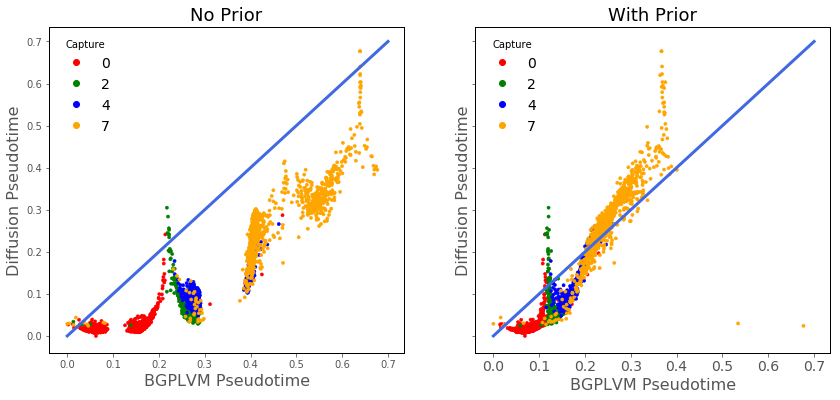

In [17]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
correlation_dpt(MapTo01(-pseudotime_np)*max(dpt), dpt, mData['capture.orig'].values, ax[0], 'No Prior')
correlation_dpt(MapTo01(pseudotime_wp)*max(dpt), dpt, mData['capture.orig'].values, ax[1], 'With Prior')